# Data Science Project - Basketball Players Analysis

# WARNING: Do not re-run this Jupyter Notebook. The data is confidential and not included in this submission.

## Background and Motivation

- One of the popular sports in the U.S. is basketball. One of the most important days in any sport is game day. Prathusha did an internship with the basketball team and this idea fascinated the others. Because of the interest in basketball and the importance of game day, we are trying to predict the performance on game day based on various factors taken into consideration for our home team.
- There are variety of factors taken into consideration for the analysis and prediction. For example, players’ performance leading up to game day, injuries, and the influence of a player on the overall team performance


## Project Objectives

- Prediction of the performance of individual players as game day arrives is based on various deciding factors like injury, player involvement, and other measures of performance for each practice. Game day is quite stressful, but also an important day to perform well. Without adding more pressure on the team to perform well on game day, our analytics will help the home team to win the match based on their performance on each day.
- We will use the factors injury, duration of each player’s practice, and the performance of each of the players as game day approaches, to do supervised and unsupervised analysis. Various factors will be used in these analyses to get maximum achieved performance on game day.
- Implementing strategic analysis methods will increase the probability of the team winning games in the future as well as reduce injuries.


##  Input data

In [1]:
# imports and setup 

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords

import re

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

In [2]:
# Input file1 containing data of players and their performance, 
# injury stataus and exertion and exertion criteria
analysis_data = pd.read_csv("Prathusha CS Project Data.csv")

In [3]:
# Renaming columns
analysis_data = analysis_data.rename(columns={'rpe': 'Rating_Perceived_Exertion', 'dur': 'Duration_Activity','minply': 'Minutes_played_game','trimp': 'Training_Impulse','TPR':'Team_Performance_Rating'})

In [4]:
# Input file2 containing data of game and Wins and losses or  
# and sttaistics of home team and opponenet team
game_data = pd.read_csv("Prathusha CS Project GAMELOGS.csv", header=1)

In [5]:
# Here we remove any empty columns
game_data = game_data.dropna(axis=1, how='all')

In [6]:
# Renaming columns
game_data = game_data.rename(columns={'H/A/N': 'Game_Location', 'W/L': 'Game_Result'})

In [7]:
# Removing bad data
analysis_data=analysis_data[analysis_data['ActivityType'] != 3]

In [8]:
# considering only players data
player_data = analysis_data[analysis_data.iloc[:, 0] != "TEAM"]

## Exploring the Data

In [9]:
analysis_data.describe()

,InjuryStatus,InjuryType,ActivityType,Rating_Perceived_Exertion,Duration_Activity,Minutes_played_game,Training_Impulse,Team_Performance_Rating
count,5665.000000,5665.000000,5664.000000,5553.000000,5680.000000,1295.000000,5592.000000,58.000000
mean,0.207237,0.171403,0.883121,2.332267,94.454544,10.820783,307.958549,50.973099
std,0.651040,0.594015,0.675055,1.998249,67.060802,12.345886,300.388039,30.243924
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304551
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.737168
50%,0.000000,0.000000,1.000000,3.000000,119.000000,3.000000,300.000000,52.041566
75%,0.000000,0.000000,1.000000,4.000000,150.000000,21.838889,500.000000,76.506879
max,6.000000,6.000000,2.000000,10.000000,214.000000,47.000000,1712.000000,99.917358


There are ~5500 data recorded. There are very few instances of an injury. Most of the data that is recorded is for practices.

In [10]:
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5699 entries, 0 to 5699
Data columns (total 13 columns):
PlayerID                     5699 non-null object
date                         5699 non-null object
InjuryStatus                 5665 non-null float64
InjuryType                   5665 non-null float64
ActivityType                 5664 non-null float64
Rating_Perceived_Exertion    5553 non-null float64
Duration_Activity            5680 non-null float64
Minutes_played_game          1295 non-null float64
Training_Impulse             5592 non-null float64
Location                     3780 non-null object
Opponent                     895 non-null object
Date_Act_Loc_Opp             5699 non-null object
Team_Performance_Rating      58 non-null float64
dtypes: float64(8), object(5)
memory usage: 623.3+ KB


In [11]:
num_ath = len(analysis_data.PlayerID.unique())
# We have to subtract one because there are team values for each day.
print("There are " + str(num_ath-1) + " athletes on the Basketball team.")

There are 24 athletes on the Basketball team.


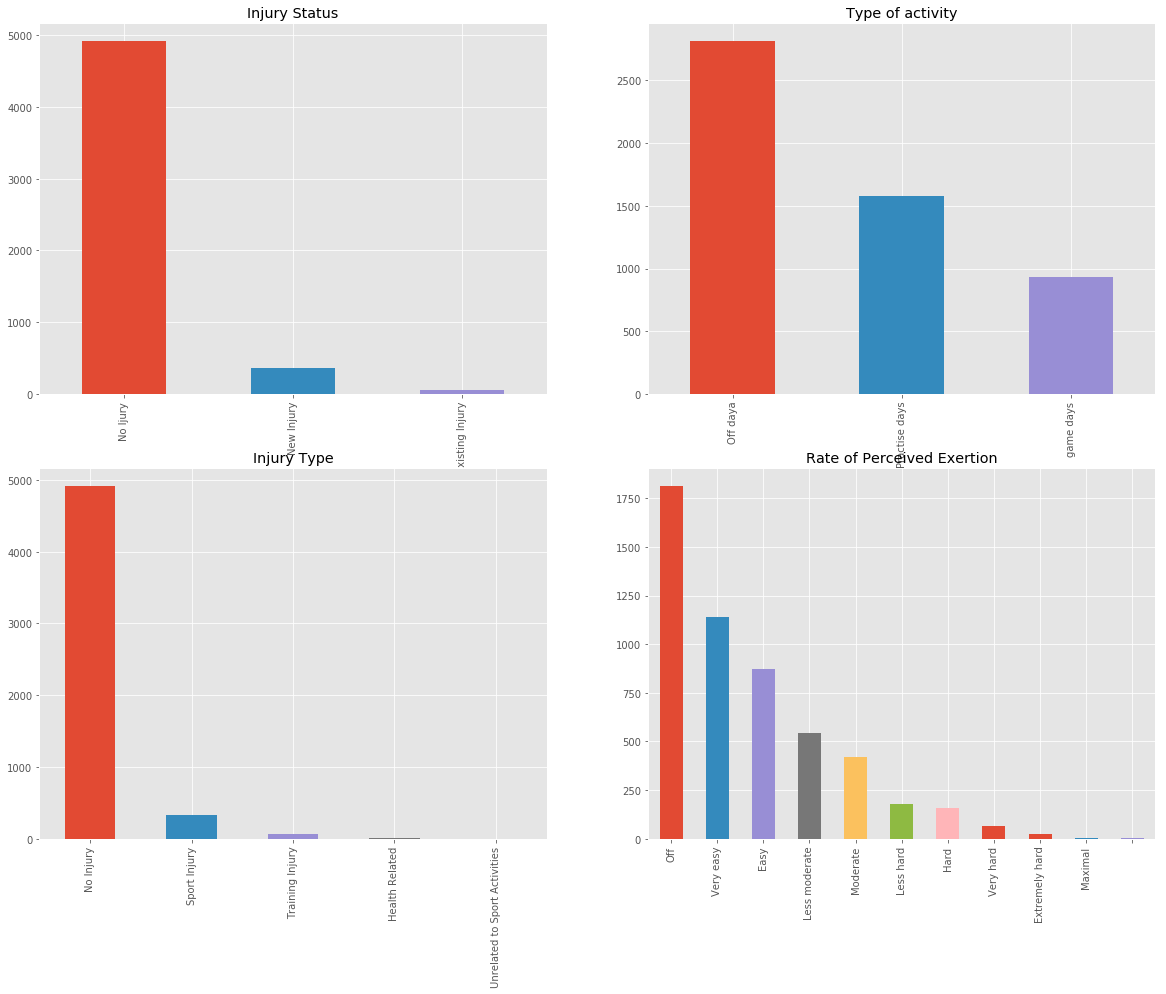

In [12]:
# Plot Categorical variables: InjuryStatus,InjuryType,ActivityType,Rating_Perceived_Exertion
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

x1_labels = ("No Ijury","New Injury","Existing Injury")
ax1 = player_data["InjuryStatus"].value_counts().plot(kind='bar',ax=axes[0,0])
ax1.set_xticklabels(x1_labels)
ax1.set_title('Injury Status');
x2_labels = ("No Injury","Sport Injury","Training Injury","Health Related",'Unrelated to Sport Activities')
ax2 = player_data["InjuryType"].value_counts().plot(kind='bar',ax=axes[1,0])
ax2.set_xticklabels(x2_labels)
ax2.set_title('Injury Type');
x3_labels = ("Off daya","Practise days","game days")
ax3 = player_data["ActivityType"].value_counts().plot(kind='bar',ax=axes[0,1])
ax3.set_xticklabels(x3_labels)
ax3.set_title('Type of activity');
x4_labels = ("Off","Very easy","Easy","Less moderate","Moderate","Less hard","Hard","Very hard","Extremely hard","Maximal")
ax4 = player_data["Rating_Perceived_Exertion"].value_counts().plot(kind='bar',ax=axes[1,1]);
ax4.set_xticklabels(x4_labels)
ax4.set_title('Rate of Perceived Exertion')
plt.savefig("overview")

Figure 1: This figure shows the counts of each categorical variable above over all of the data.

In [13]:
game_data.describe()

,UTAH_POINTS,OPPONENT_POINTS,UTAH_FG,UTAH_FGA,UTAH_FG%,UTAH_3P,UTAH_3PA,UTAH_3P%,UTAH_FT,UTAH_FTA,...,OPPONENT_FT,OPPONENT_FTA,OPPONENT_FT%,OPPONENT_ORB,OPPONENT_TRB,OPPONENT_AST,OPPONENT_STL,OPPONENT_BLK,OPPONENT_TOV,OPPONENT_PF
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,...,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,76.064516,68.419355,27.161290,56.370968,0.482306,7.887097,21.887097,0.358500,13.854839,19.258065,...,12.387097,17.693548,0.699355,8.080645,30.032258,11.387097,6.225806,3.145161,11.790323,19.370968
std,10.423603,12.144686,4.620672,6.648638,0.060615,3.003303,5.018343,0.105145,5.878125,7.531215,...,4.836185,6.053284,0.107163,3.053074,5.034203,3.939522,2.977618,2.118202,3.383359,4.304911
min,55.000000,37.000000,18.000000,41.000000,0.350000,2.000000,12.000000,0.100000,2.000000,4.000000,...,4.000000,6.000000,0.467000,1.000000,20.000000,2.000000,0.000000,0.000000,5.000000,8.000000
25%,67.000000,60.000000,24.000000,53.250000,0.441000,6.000000,19.000000,0.286000,9.000000,13.000000,...,9.000000,13.000000,0.637750,6.000000,27.000000,9.000000,4.000000,1.250000,10.000000,17.000000
50%,76.500000,68.500000,26.000000,56.000000,0.484500,8.000000,21.500000,0.372500,13.500000,19.000000,...,12.000000,17.500000,0.714000,7.500000,30.000000,11.000000,6.000000,3.000000,12.000000,19.000000
75%,84.750000,78.000000,30.000000,61.000000,0.519000,10.000000,25.500000,0.438000,18.000000,23.750000,...,15.000000,21.750000,0.783000,11.000000,32.750000,14.000000,8.000000,4.750000,14.000000,22.000000
max,96.000000,94.000000,39.000000,71.000000,0.600000,15.000000,36.000000,0.583000,29.000000,36.000000,...,30.000000,36.000000,0.909000,15.000000,44.000000,19.000000,14.000000,10.000000,22.000000,31.000000


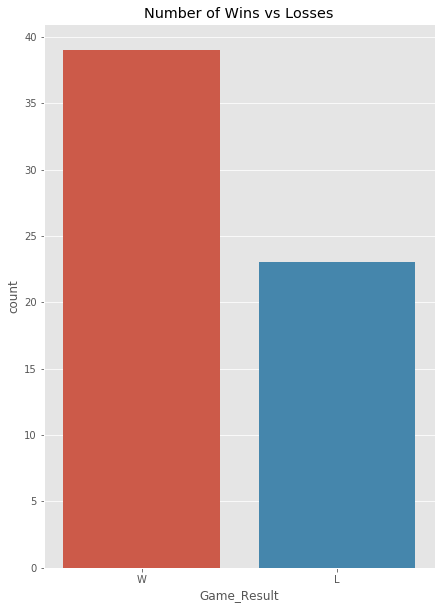

In [14]:
# Show categorical variables
import seaborn as sns
plt.figure(figsize=(7,10))
plt.title("Number of Wins vs Losses")
sns.countplot(x="Game_Result", data=game_data)
plt.savefig('gameresult')

Figure 2: This graph shows the number 

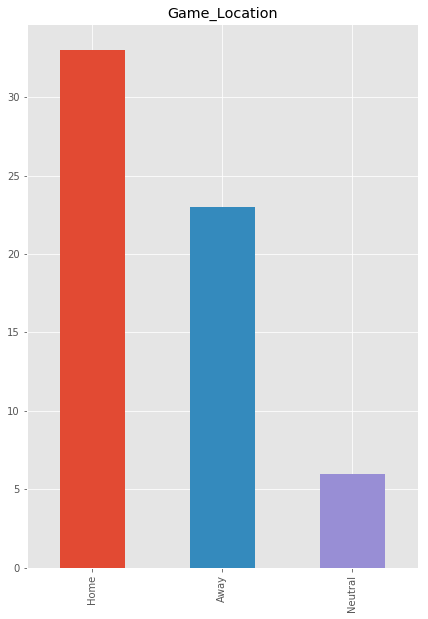

In [15]:
# Game location variable

x1_labels = ("Home","Away","Neutral")
plt.figure(figsize = (7,10))
ax1 = game_data["Game_Location"].value_counts().plot(kind='bar')
ax1.set_xticklabels(x1_labels)
ax1.set_title('Game_Location')
plt.savefig('gamelocation')


From above distribution, it is clear that most of the games are played on home ground than other places.

In [16]:
game_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 38 columns):
Date               62 non-null object
Game_Location      62 non-null object
Opponent           62 non-null object
Game_Result        62 non-null object
UTAH_POINTS        62 non-null int64
OPPONENT_POINTS    62 non-null int64
UTAH_FG            62 non-null int64
UTAH_FGA           62 non-null int64
UTAH_FG%           62 non-null float64
UTAH_3P            62 non-null int64
UTAH_3PA           62 non-null int64
UTAH_3P%           62 non-null float64
UTAH_FT            62 non-null int64
UTAH_FTA           62 non-null int64
UTAH_FT%           62 non-null float64
UTAH_ORB           62 non-null int64
UTAH_TRB           62 non-null int64
UTAH_AST           62 non-null int64
UTAH_STL           62 non-null int64
UTAH_BLK           62 non-null int64
UTAH_TOV           62 non-null int64
UTAH_PF            62 non-null int64
OPPONENT_FG        62 non-null int64
OPPONENT_FGA       62 non-null int64

There is 62 records in the game log file that contains records of win/lose of home team and performance to different opponent.

## Data Visualization

### Data Exploration of Practices VS Game VS Off Days

In [17]:
#Group the data by date and Activity Type, find the size of each ActivityType in each day
date_activity = analysis_data.groupby(['date','ActivityType']).size()
#make a datframe for grouped data
activity_frame = pd.DataFrame(date_activity.reset_index())
activity_frame.columns = ['date','ActivityType','sum']
#Convert date into date format and sort it
activity_frame['date'] = pd.to_datetime(activity_frame.date)
activity_frame.sort_values(['date']).reset_index(drop= True)

,date,ActivityType,sum
0,2016-10-01,0.0,1
1,2016-10-01,1.0,14
2,2016-10-02,0.0,15
3,2016-10-03,1.0,16
4,2016-10-04,1.0,16
5,2016-10-05,0.0,16
6,2016-10-06,1.0,16
7,2016-10-07,1.0,16
8,2016-10-08,1.0,16
9,2016-10-09,0.0,16


In [18]:
#Due to the large number of data, we group the date by month.
activity_frame['year'] = [y.year for y in activity_frame['date']]
activity_frame['month'] = [m.month for m in activity_frame['date']]

In [19]:
#Group off days data by year and month
off = activity_frame.loc[activity_frame['ActivityType'] == 0.0]
off.sort_values(['date']).reset_index(drop=True)
off = off.groupby(['year','month'])['sum'].sum().reset_index(drop=True)
off = pd.DataFrame(off)

#Group practice days data by year and month
practice = activity_frame.loc[activity_frame['ActivityType'] == 1.0]
practice.sort_values(['date']).reset_index(drop=True)
practice = practice.groupby(['year','month'])['sum'].sum().reset_index(drop=True)
practice = practice.append(pd.DataFrame([0]), ignore_index =True)
practice.columns = ['sum']

#Group game days data by year and month
game = activity_frame.loc[activity_frame['ActivityType'] == 2.0]
game.sort_values(['date']).reset_index(drop=True)
game = game.groupby(['year','month'])['sum'].sum().reset_index(drop=True)
game = game.append(pd.DataFrame([0,0,0]), ignore_index =True)
game.columns = ['sum']

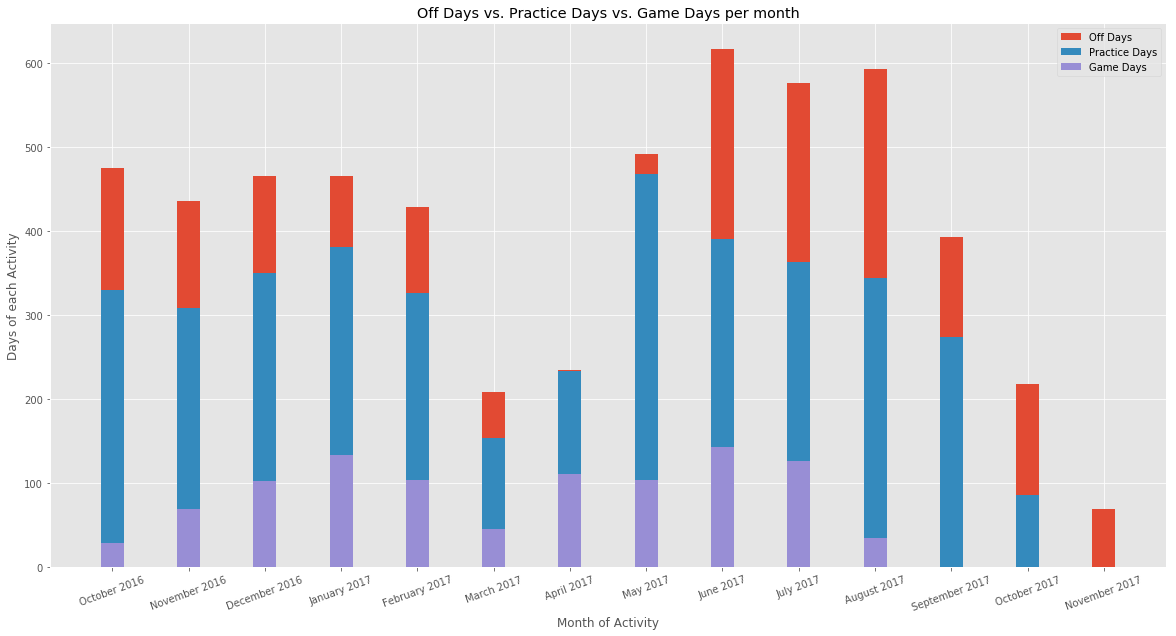

In [20]:
import calendar
#Make bar plot for each type of activity
plt.figure(figsize=(20,10))
plt.title("Off Days vs. Practice Days vs. Game Days per month")
plt.bar(off.index, off['sum'], width = 0.3,label='Off Days', bottom = practice['sum'] + game['sum'])
plt.bar(practice.index, practice['sum'],  width = 0.3,label='Practice Days', bottom = game['sum'])
plt.bar(game.index, game['sum'],  width = 0.3,label='Game Days')
plt.xticks(np.arange(14), ("October 2016", "November 2016", "December 2016", "January 2017", "February 2017", "March 2017", "April 2017", "May 2017", "June 2017", "July 2017", "August 2017", "September 2017", "October 2017", "November 2017"), rotation=20)
plt.xlabel('Month of Activity')
plt.ylabel('Days of each Activity')
plt.legend()
plt.savefig('gamevsoffvspr')

Figure 1: This graph shows the number of days with respect to each activity for each month. It covers two seasons of data as well as data for off-season days.

### Influence of injury on player performance

In [52]:
player_data = analysis_data[analysis_data.iloc[:, 0] != "TEAM"]

In [53]:
player_data.dtypes

PlayerID                      object
date                          object
InjuryStatus                 float64
InjuryType                   float64
ActivityType                 float64
Rating_Perceived_Exertion    float64
Duration_Activity            float64
Minutes_played_game          float64
Training_Impulse             float64
Location                      object
Opponent                      object
Date_Act_Loc_Opp              object
Team_Performance_Rating      float64
dtype: object

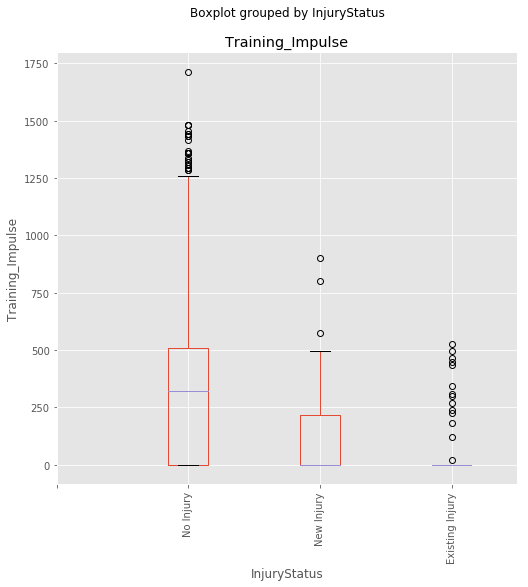

In [78]:
player_data.boxplot(column="Training_Impulse",by= "InjuryStatus",figsize = (8,8))
labels = ['',"No Injury","New Injury","Existing Injury"]
plt.xticks([0,1,2,3],labels, rotation='vertical')
plt.ylabel("Training_Impulse")
plt.savefig('injuryperformance')

From the graph above, it is clear that when there is no injury, then the team performance improves. The new injuries seems to decrease the team performace and  still has positive values since other players compensate injured players performance to a significant level.

We still show potential for better performance when there are no injuries and decreasing performance as time with the injury continues. Thereby when the coach  is selecting the players for the game day, he needs comcentrate more on the palayer with no injury and try avoid players with existing injuries.

Note: We do not have access to the units for any of these variables.

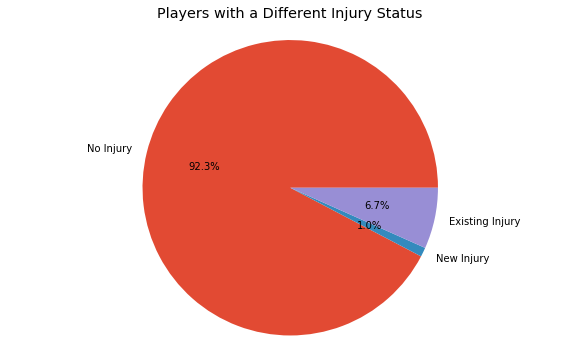

In [55]:
# Pie plot for injury status
injury_status = player_data.groupby("InjuryStatus").apply(lambda players: len(players))
#injury_status
plt.title("Players with a Different Injury Status")
plt.pie(injury_status, explode = (0,0,0), labels = ["No Injury", "New Injury", "Existing Injury"], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Figure 3: This pie chart shows the percentages of basketball players who have each of the following injury status: No Injury, New Injury, and Existing Injury.

([<matplotlib.axis.XTick at 0x116b24160>,
 <a list of 6 Text xticklabel objects>)

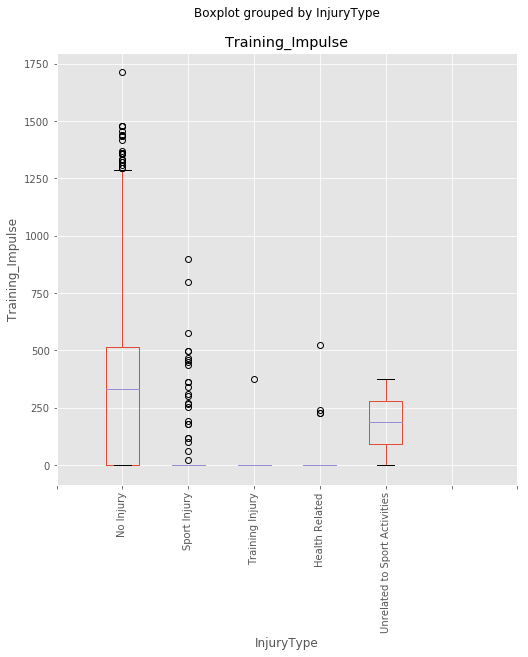

In [56]:
player_data.boxplot(column="Training_Impulse",by= "InjuryType",figsize = (8,8))
plt.xlabel('InjuryType')
plt.ylabel('Training_Impulse')
labels = ['',"No Injury","Sport Injury","Training Injury","Health Related",'Unrelated to Sport Activities']
plt.xticks([0,1,2,3,4,5,6,7],labels, rotation='vertical')

The intensity of the injury type also decreases the performance of each player.

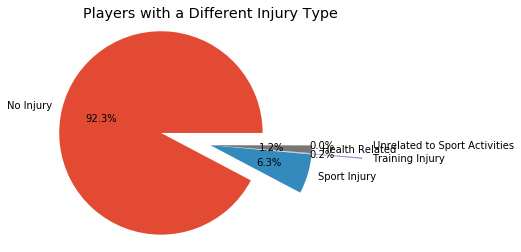

In [27]:
# Pie plot for injury type
injury_type = player_data.groupby("InjuryType").apply(lambda players: len(players))
#injury_type
plt.title("Players with a Different Injury Type")
plt.pie(injury_type, explode = (0.5,0,0.5,0,0.5), labels = ["No Injury", "Sport Injury", "Training Injury", "Health Related", "Unrelated to Sport Activities"], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Figure 5: This pie chart shows the percentages of basketball players who have each of the following injury type: No Injury, Sport Injury, Training Injury, Health Related, and Unrelated to Sport Activities.

### Prediction of performance on game day

In [28]:
team_game_data = team_data[team_data.loc[:, "ActivityType"] == 2]

NameError: name 'team_data' is not defined

In [59]:
team_game_data.corr()

NameError: name 'team_game_data' is not defined

#### Relation between performace of each player and exertion rate

Text(0,0.5,'Training Impulse')

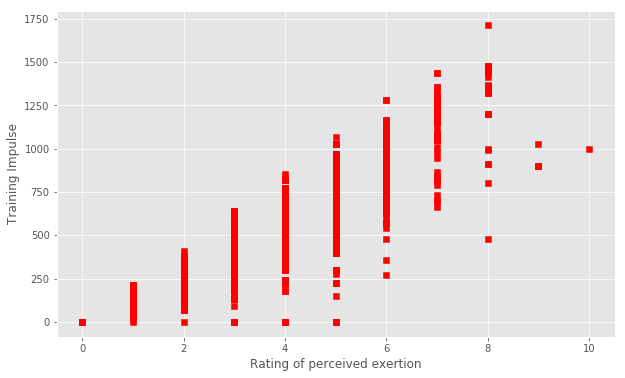

In [60]:
plt.scatter(x=player_data['Rating_Perceived_Exertion'],y=player_data['Training_Impulse'],c='r',marker='s')

plt.xlabel('Rating of perceived exertion')
plt.ylabel('Training Impulse')

From the plot above, it is clear that the rate of exertion is from 8 to 10, which is from hard to very hard exertion. This rate of exertion has more influence on performance of each player than extremely hard (9) and maximum (10) exertion rates.

In [29]:
game_data['Date']

0     11/12/2016
1     11/15/2016
2     11/18/2016
3     11/25/2016
4     11/28/2016
5      12/1/2016
6      12/6/2016
7     12/10/2016
8     12/17/2016
9     12/22/2016
10    12/23/2016
11    12/25/2016
12      1/1/2017
13      1/5/2017
14      1/7/2017
15     1/12/2017
16     1/14/2017
17     1/18/2017
18     1/21/2017
19     1/26/2017
20     1/28/2017
21      2/2/2017
22      2/4/2017
23      2/9/2017
24     2/11/2017
25     2/16/2017
26     2/19/2017
27     2/23/2017
28      3/2/2017
29      3/4/2017
         ...    
32    11/10/2017
33    11/13/2017
34    11/16/2017
35    11/21/2017
36    11/23/2017
37    11/24/2017
38     12/2/2017
39     12/5/2017
40     12/9/2017
41    12/16/2017
42    12/20/2017
43    12/29/2017
44    12/31/2017
45      1/4/2018
46      1/7/2018
47     1/11/2018
48     1/14/2018
49     1/18/2018
50     1/21/2018
51     1/25/2018
52     1/27/2018
53      2/2/2018
54      2/8/2018
55     2/10/2018
56     2/15/2018
57     2/17/2018
58     2/22/2018
59     2/24/20

#### Influence of activity type on performance of the player

([<matplotlib.axis.XTick at 0x1183a3a20>,
 <a list of 3 Text xticklabel objects>)

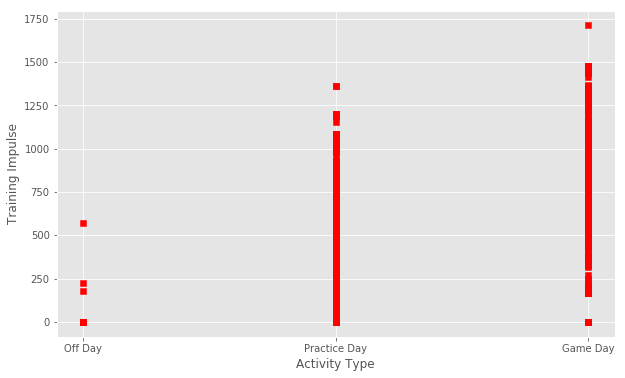

In [62]:
plt.scatter(x=player_data['ActivityType'],y=player_data['Training_Impulse'],c='r',marker='s')

plt.xlabel('Activity Type')
plt.ylabel('Training Impulse')
plt.xticks(np.arange(3), ("Off Day", "Practice Day", "Game Day"))

Performance of each player on the game day is better than on the practice days.

### Visualization of Game log data:

In [63]:
game_data.dtypes

Date                object
Game_Location       object
Opponent            object
Game_Result         object
UTAH_POINTS          int64
OPPONENT_POINTS      int64
UTAH_FG              int64
UTAH_FGA             int64
UTAH_FG%           float64
UTAH_3P              int64
UTAH_3PA             int64
UTAH_3P%           float64
UTAH_FT              int64
UTAH_FTA             int64
UTAH_FT%           float64
UTAH_ORB             int64
UTAH_TRB             int64
UTAH_AST             int64
UTAH_STL             int64
UTAH_BLK             int64
UTAH_TOV             int64
UTAH_PF              int64
OPPONENT_FG          int64
OPPONENT_FGA         int64
OPPONENT_FG%       float64
OPPONENT_3P          int64
OPPONENT_3PA         int64
OPPONENT_3P%       float64
OPPONENT_FT          int64
OPPONENT_FTA         int64
OPPONENT_FT%       float64
OPPONENT_ORB         int64
OPPONENT_TRB         int64
OPPONENT_AST         int64
OPPONENT_STL         int64
OPPONENT_BLK         int64
OPPONENT_TOV         int64
O

In [64]:
game_data["Date"] = pd.to_datetime(game_data["Date"])

In [65]:
game_data.corr()

,UTAH_POINTS,OPPONENT_POINTS,UTAH_FG,UTAH_FGA,UTAH_FG%,UTAH_3P,UTAH_3PA,UTAH_3P%,UTAH_FT,UTAH_FTA,...,OPPONENT_FT,OPPONENT_FTA,OPPONENT_FT%,OPPONENT_ORB,OPPONENT_TRB,OPPONENT_AST,OPPONENT_STL,OPPONENT_BLK,OPPONENT_TOV,OPPONENT_PF
UTAH_POINTS,1.000000,-0.087370,0.778880,0.387588,0.667541,0.418644,0.103248,0.520005,0.334867,0.361056,...,-0.007983,0.100347,-0.210460,0.146130,-0.161555,-0.102818,-0.049598,-0.068739,0.056171,0.258844
OPPONENT_POINTS,-0.087370,1.000000,-0.043876,0.042707,-0.083977,-0.073739,-0.108686,-0.004878,-0.048276,-0.091895,...,0.320684,0.213398,0.313428,0.115794,0.223936,0.683548,0.187284,0.153724,-0.171375,-0.054762
UTAH_FG,0.778880,-0.043876,1.000000,0.662378,0.695290,0.139548,-0.133527,0.358076,-0.262280,-0.183526,...,-0.170102,-0.063261,-0.228920,0.008359,-0.157386,0.021730,-0.084904,0.027717,-0.120489,-0.228872
UTAH_FGA,0.387588,0.042707,0.662378,1.000000,-0.071636,0.045644,0.139341,-0.052048,-0.377379,-0.348000,...,-0.239066,-0.153544,-0.178759,-0.038648,0.225428,0.095821,-0.015894,0.304586,-0.097784,-0.383482
UTAH_FG%,0.667541,-0.083977,0.695290,-0.071636,1.000000,0.140585,-0.309231,0.515715,0.018807,0.100914,...,0.038791,0.087473,-0.091642,0.045485,-0.417517,-0.055632,-0.095942,-0.237966,-0.039330,0.077522
UTAH_3P,0.418644,-0.073739,0.139548,0.045644,0.140585,1.000000,0.721376,0.733674,0.012057,-0.038554,...,-0.033059,-0.042513,0.003896,0.353218,0.167223,-0.026728,0.039561,-0.036036,0.008925,-0.075321
UTAH_3PA,0.103248,-0.108686,-0.133527,0.139341,-0.309231,0.721376,1.000000,0.077625,0.024444,-0.086835,...,-0.060989,-0.137691,0.167948,0.375094,0.379754,-0.084821,0.135579,-0.111014,0.098997,-0.105784
UTAH_3P%,0.520005,-0.004878,0.358076,-0.052048,0.515715,0.733674,0.077625,1.000000,-0.015689,0.021199,...,0.019762,0.092892,-0.172847,0.164310,-0.114189,0.000435,-0.104776,0.058407,-0.126151,-0.002083
UTAH_FT,0.334867,-0.048276,-0.262280,-0.377379,0.018807,0.012057,0.024444,-0.015689,1.000000,0.948485,...,0.270161,0.299121,-0.015298,0.065519,-0.124487,-0.202832,0.025319,-0.147059,0.284475,0.857311
UTAH_FTA,0.361056,-0.091895,-0.183526,-0.348000,0.100914,-0.038554,-0.086835,0.021199,0.948485,1.000000,...,0.238012,0.307060,-0.088433,0.008349,-0.174043,-0.233278,0.042683,-0.100012,0.223476,0.881868


Text(0,0.5,'Win/Lose')

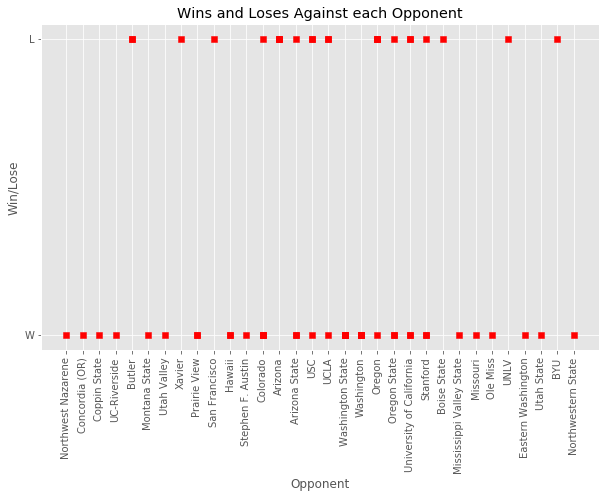

In [66]:
plt.scatter(x=game_data.loc[:,'Opponent'],y=game_data.loc[:,'Game_Result'],c='r',marker='s')
plt.xticks(rotation=90)
plt.title("Wins and Loses Against each Opponent")
plt.xlabel('Opponent')
plt.ylabel('Win/Lose')

Figure ?: This graph shows us which opponents we won against and lost against. If there is only one dot for an opponent, we either only played against them once or we won or lost in both games.

We won most of our games. We won both times against half of the other universities and lost both times against a few of the universities. There were also a few universities where we won once and lost the other time.

### Combining the dataframes to get overall performance and influence on various factors

In [47]:
# Here we have to rename the date column so that we can merge it with the Date column in the other dataframe
analysis_data.rename(index=str, columns={"date": "Date"}, inplace=True)

# We need to change the "Date" column in game_data back to an object type to merge them
org_game_data = pd.read_csv("Prathusha CS Project GAMELOGS.csv", header=1)

# We have to change the names of the columns of the new data to match the old data
org_game_data.rename(index=str, columns={"H/A/N": "Game_Location", "W/L": "Game_Result"}, inplace=True)

analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5699 entries, 0 to 5699
Data columns (total 13 columns):
PlayerID                     5699 non-null object
Date                         5699 non-null object
InjuryStatus                 5665 non-null float64
InjuryType                   5665 non-null float64
ActivityType                 5664 non-null float64
Rating_Perceived_Exertion    5553 non-null float64
Duration_Activity            5680 non-null float64
Minutes_played_game          1295 non-null float64
Training_Impulse             5592 non-null float64
Location                     3780 non-null object
Opponent                     895 non-null object
Date_Act_Loc_Opp             5699 non-null object
Team_Performance_Rating      58 non-null float64
dtypes: float64(8), object(5)
memory usage: 623.3+ KB


In [49]:
Complete_data = org_game_data[['Date', 'Game_Location','Opponent','Game_Result','UTAH_POINTS','OPPONENT_POINTS']].merge(analysis_data[['Date','PlayerID','InjuryStatus','ActivityType','Rating_Perceived_Exertion','Duration_Activity','Training_Impulse','Team_Performance_Rating']], on='Date', how='outer')

In [50]:
Complete_data.describe()

,UTAH_POINTS,OPPONENT_POINTS,InjuryStatus,ActivityType,Rating_Perceived_Exertion,Duration_Activity,Training_Impulse,Team_Performance_Rating
count,1040.000000,1040.000000,5665.000000,5664.000000,5553.000000,5680.000000,5592.000000,58.000000
mean,75.875000,68.382692,0.207237,0.883121,2.332267,94.454544,307.958549,50.973099
std,10.256468,12.048973,0.651040,0.675055,1.998249,67.060802,300.388039,30.243924
min,55.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.304551
25%,67.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.737168
50%,77.000000,68.000000,0.000000,1.000000,3.000000,119.000000,300.000000,52.041566
75%,84.000000,78.000000,0.000000,1.000000,4.000000,150.000000,500.000000,76.506879
max,96.000000,94.000000,6.000000,2.000000,10.000000,214.000000,1712.000000,99.917358


In [51]:
Complete_data.dtypes

Date                          object
Game_Location                 object
Opponent                      object
Game_Result                   object
UTAH_POINTS                  float64
OPPONENT_POINTS              float64
PlayerID                      object
InjuryStatus                 float64
ActivityType                 float64
Rating_Perceived_Exertion    float64
Duration_Activity            float64
Training_Impulse             float64
Team_Performance_Rating      float64
dtype: object

In [42]:
Complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5700 entries, 0 to 5699
Data columns (total 13 columns):
Date                         5700 non-null object
Game_Location                1040 non-null object
Opponent                     1040 non-null object
Game_Result                  1040 non-null object
UTAH_POINTS                  1040 non-null float64
OPPONENT_POINTS              1040 non-null float64
PlayerID                     5699 non-null object
InjuryStatus                 5665 non-null float64
ActivityType                 5664 non-null float64
Rating_Perceived_Exertion    5553 non-null float64
Duration_Activity            5680 non-null float64
Training_Impulse             5592 non-null float64
Team_Performance_Rating      58 non-null float64
dtypes: float64(8), object(5)
memory usage: 623.4+ KB


#### Factors influencing the team overall performance

In [43]:
Complete_data.corr()

,UTAH_POINTS,OPPONENT_POINTS,InjuryStatus,ActivityType,Rating_Perceived_Exertion,Duration_Activity,Training_Impulse,Team_Performance_Rating
UTAH_POINTS,1.000000,-0.089442,0.026904,0.075537,0.062948,0.128532,0.080504,0.320676
OPPONENT_POINTS,-0.089442,1.000000,-0.043230,-0.009539,-0.076008,0.031291,-0.048474,-0.620750
InjuryStatus,0.026904,-0.043230,1.000000,-0.218753,-0.196667,-0.232241,-0.175114,-0.084130
ActivityType,0.075537,-0.009539,-0.218753,1.000000,0.639657,0.897283,0.634396,NaN
Rating_Perceived_Exertion,0.062948,-0.076008,-0.196667,0.639657,1.000000,0.723979,0.938869,0.145926
Duration_Activity,0.128532,0.031291,-0.232241,0.897283,0.723979,1.000000,0.746679,-0.040042
Training_Impulse,0.080504,-0.048474,-0.175114,0.634396,0.938869,0.746679,1.000000,0.186496
Team_Performance_Rating,0.320676,-0.620750,-0.084130,NaN,0.145926,-0.040042,0.186496,1.000000


Nothing is highly correlated with the performance of the team. The higher correlations make sense, but do not contribute to our mission to predict performance.

## Analysis of Performance

In [44]:
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')
# Create color maps
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])


## Analysing data by building models

In [53]:
# Calculations of average trimp for each day

ave_trimp = player_data.groupby("date")["Training_Impulse"].apply(lambda players: sum(players)/len(players))
ave_trimp = pd.DataFrame(ave_trimp).reset_index()
#ave_trimp

In [54]:
org_game_data.rename(index=str, columns={"H/A/N": "Game_Location", "W/L": "Game_Result"}, inplace=True)

In [55]:
# Making the combined dataset with trimp and W/L
# Here we have to rename the date column so that we can merge it with the Date column in the other dataframe
ave_trimp.rename(index=str, columns={"date": "Date"}, inplace=True)
ave_trimp.info()
trimp_WL = org_game_data[['Date', 'Game_Location','Opponent','Game_Result','UTAH_POINTS','OPPONENT_POINTS']].merge(ave_trimp, on='Date', how='outer')

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 332
Data columns (total 2 columns):
Date                333 non-null object
Training_Impulse    333 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.8+ KB


In [56]:
game_trimp_wl = trimp_WL.iloc[0:61]
game_trimp_wl.dtypes

Date                 object
Game_Location        object
Opponent             object
Game_Result          object
UTAH_POINTS         float64
OPPONENT_POINTS     float64
Training_Impulse    float64
dtype: object

In [57]:
# replace rows with 0 trimp to 0 value and convert it into integer data type
import math

game_trimp_wl = np.nan_to_num(game_trimp_wl)
game_trimp_wl = pd.DataFrame(game_trimp_wl, columns=['Date','H/A/N','Opponent','W/L','UTAH_POINTS','OPPONENT_POINTS','trimp'])

i = 0
while i <61:
    if(math.isnan(game_trimp_wl['trimp'].iloc[i])):
        game_trimp_wl['trimp'].iloc[i] = 0
    else:
        game_trimp_wl['trimp'].iloc[i] = int(game_trimp_wl['trimp'].iloc[i])
    i += 1

In [58]:
# Splitting the data frame into X and Y - independent and dependent varaibles
# & into traiing and testing datas
labels =["W", "L"]

def splitData(features):
    predictors = game_trimp_wl[features].as_matrix()
    labels = game_trimp_wl["W/L"].as_matrix()

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(predictors, labels, random_state=1, test_size=0.5)
    return XTrain, XTest, yTrain, yTest

In [59]:
game_trimp_wl

,Date,H/A/N,Opponent,W/L,UTAH_POINTS,OPPONENT_POINTS,trimp
0,11/12/2016,H,Northwest Nazarene,W,81,37,617
1,11/15/2016,H,Concordia (OR),W,96,53,578
2,11/18/2016,H,Coppin State,W,94,51,530
3,11/25/2016,H,UC-Riverside,W,85,67,540
4,11/28/2016,H,Butler,L,59,68,552
5,12/1/2016,H,Montana State,W,92,84,542
6,12/6/2016,H,Utah Valley,W,87,80,572
7,12/10/2016,A,Xavier,L,69,77,467
8,12/17/2016,H,Prairie View,W,92,60,578
9,12/22/2016,N,San Francisco,L,86,89,526


### Building SVM model

#### Building a SVM model to predict Win or Loss based on Training impulse values 

In [60]:
# Building a SVM model
XTrain, XTest, yTrain, yTest = splitData(["trimp"])

model2 = svm.SVC(kernel='rbf', C=100)
model2.fit(XTrain, yTrain)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [61]:
# Confusion matrix and accuracy of SVM model
print('Confusion Matrix:')
y_pred = model2.predict(XTest)
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))
print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

# With test_size 0.5 we get 60% accuracy and with test_size 0.7 we get 58% accuracy and 
# with test_size 0.3 we get 73% accuracy

Confusion Matrix:
[[ 3 11]
 [ 1 16]]
Accuracy =  0.6129032258064516


#### Building a SVM model to predict Win or Loss based on type of points scored by Utah 

In [62]:
# Building a SVM model
XTrain, XTest, yTrain, yTest = splitData(["UTAH_POINTS"])

model = svm.SVC(kernel='rbf', C=100)
model.fit(XTrain, yTrain)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
# Confusion matrix and accuracy of SVM model
print('Confusion Matrix:')
y_pred = model2.predict(XTest)
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))
print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Confusion Matrix:
[[ 0 14]
 [ 0 17]]
Accuracy =  0.5483870967741935


# Decision Trees

In [64]:
# Calculations of average trimp for each day
# Setup for use in decision tree
player_data = player_data.fillna(0)
ave_trimp = player_data.groupby("date")["Training_Impulse"].apply(lambda players: int(sum(players)/len(players)))
ave_trimp = pd.DataFrame(ave_trimp).reset_index()

In [65]:
# Making the combined dataset with trimp and W/L
# Here we have to rename the date column so that we can merge it with the Date column in the other dataframe
ave_trimp.rename(index=str, columns={"date": "Date"}, inplace=True)
ave_trimp.info()

trimp_WL = org_game_data[['Date', 'Game_Location','Opponent','Game_Result','UTAH_POINTS','OPPONENT_POINTS']].merge(ave_trimp, on='Date', how='outer')

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 332
Data columns (total 2 columns):
Date                333 non-null object
Training_Impulse    333 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.8+ KB


In [66]:
game_trimp_wl = trimp_WL.iloc[0:61]


In [67]:
import math

game_trimp_wl = np.nan_to_num(game_trimp_wl)
game_trimp_wl = pd.DataFrame(game_trimp_wl, columns=['Date','Game_Location','Opponent','Game_Result','UTAH_POINTS','OPPONENT_POINTS','Training_Impulse'])

i = 0
while i <61:
    if(math.isnan(game_trimp_wl['Training_Impulse'].iloc[i])):
        game_trimp_wl['Training_Impulse'].iloc[i] = 0
    else:
        game_trimp_wl['Training_Impulse'].iloc[i] = int(game_trimp_wl['Training_Impulse'].iloc[i])
    i += 1
    
game_trimp_wl = game_trimp_wl[['Date','Game_Location', 'Opponent', 'Game_Result', 'Training_Impulse']]

In [68]:
def convert_HAN(x):
    if x == 'H':
        return 0
    if x == 'N':
        return 1
    if x == 'A':
        return 2

game_trimp_wl['Game_Location'] = game_trimp_wl['Game_Location'].apply(convert_HAN)
game_trimp_wl['Game_Location']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     2
8     0
9     1
10    2
11    1
12    0
13    2
14    2
15    0
16    0
17    2
18    2
19    0
20    0
21    2
22    2
23    0
24    0
25    2
26    2
27    2
28    0
29    0
     ..
31    2
32    0
33    0
34    0
35    1
36    1
37    0
38    0
39    2
40    0
41    2
42    0
43    2
44    2
45    0
46    0
47    2
48    2
49    0
50    0
51    2
52    2
53    2
54    0
55    0
56    2
57    2
58    0
59    0
60    0
Name: Game_Location, Length: 61, dtype: int64

In [69]:
game_trimp_wl.head()

,Date,Game_Location,Opponent,Game_Result,Training_Impulse
0,11/12/2016,0,Northwest Nazarene,W,617
1,11/15/2016,0,Concordia (OR),W,578
2,11/18/2016,0,Coppin State,W,530
3,11/25/2016,0,UC-Riverside,W,540
4,11/28/2016,0,Butler,L,552


In [70]:
#Build decision tree
labels =["W", "L"]

def splitData(features):
    predictors = game_trimp_wl[features].as_matrix()
    labels = game_trimp_wl["Game_Result"].as_matrix()

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(predictors, labels, random_state=1, test_size=0.4)
    return XTrain, XTest, yTrain, yTest

In [71]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["L", "W"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

Accuracy on training data =  0.8055555555555556
Accuracy on test data =  0.48


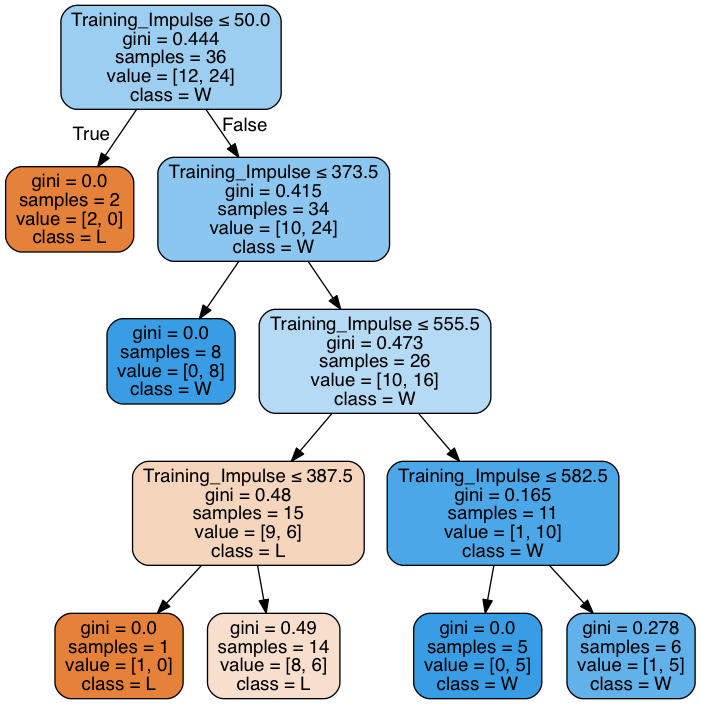

In [74]:
def decision(feature):
    decisionTree = tree.DecisionTreeClassifier(max_depth=4)

    XTrain, XTest, yTrain, yTest = splitData(feature)
    # fit the tree with the training data
    decisionTree = decisionTree.fit(XTrain, yTrain)

    # predict with the training data
    y_pred_train = decisionTree.predict(XTrain)
    # measure accuracy
    print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

    # predict with the test data
    y_pred = decisionTree.predict(XTest)
    # measure accuracy
    print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

    renderTree(decisionTree, ["Training_Impulse"])
    
decision(['Training_Impulse'])

Accuracy on training data=  0.8333333333333334
Accuracy on test data=  0.48


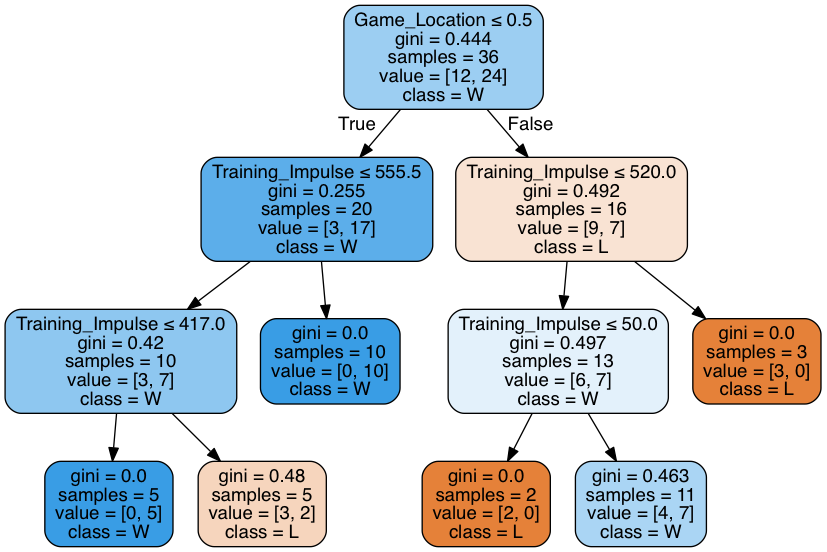

In [77]:
#Multiple features
used_features = ["Training_Impulse", "Game_Location"]
XTrain, XTest, yTrain, yTest = splitData(used_features)
decisionTree = tree.DecisionTreeClassifier(max_depth = 3)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, used_features)